# ESTUDIO AOI E IRRADIANCIA DE UNA LENTE BICONVEXA. 

Importamos las librerias

In [3]:
from pvlib import irradiance
from pvlib import location
import pandas as pd
import matplotlib.pyplot as plt
import math as m

Definimos las caracteristicas del módulo fotovoltaico: inclinaciones, tamaño y distancia focal

In [4]:
caracteristics_module={    
    'tilt':30,
    'surface_azimuth':180,
    'focal_distance': 5,
    'tam_module':30
    }

Definimos las caracteristicas de la localización.

In [5]:
caracteristics_ETSIDI_summer={
    'lat':40.405655,
    'lon':-3.700292,
    'tz':'Etc/GMT+2',
    'date':'21-06-2020',
    'temp':60
    }

Con estos datos de localización podemos crear un objeto con la función location de pvlib. 

In [6]:
site = location.Location(caracteristics_ETSIDI_summer['lat'], 
                         caracteristics_ETSIDI_summer['lon'],
                        caracteristics_ETSIDI_summer['tz'])

Creamos con panda una lista de tiempos a lo largo de un día teniendo enceunta el tz de la localización creada. 

In [7]:
times = pd.date_range(caracteristics_ETSIDI_summer['date'], freq='10min', periods=6*24,
                      tz=site.tz)

Con esta lista times, podemos obtener los datos clearsky. esta funcion get_clearsky nos devuelve un dataframe con el dni, ghi y dhi.  Con la funcion get_solarposition obtenemos un dataframe con el zenith y el azimuth

In [8]:
clearsky = site.get_clearsky(times)
solar_position = site.get_solarposition(times)

Con estos datos, podemos usar la funcion get_total_irradiance y calcular la irradiancia total que nos devuelve el poa directo, difuso y global

In [9]:
total_irrad=irradiance.get_total_irradiance( 
    surface_tilt=caracteristics_module['tilt'],
    surface_azimuth=caracteristics_module['surface_azimuth'],
    dni=clearsky['dni'],
    ghi=clearsky['ghi'],
    dhi=clearsky['dhi'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])

Tambien podemos sacar el AOI de esta localización. Sacamos el máximo y mínimo presente. 

In [10]:
AOI=irradiance.aoi( caracteristics_module['tilt'],
                   caracteristics_module['surface_azimuth'],
                   solar_position['apparent_zenith'], 
                   solar_position['azimuth'])
min_AOI=min(AOI)
max_AOI=max(AOI)

Definimos una función que calcula el máximo AOIaprovechable dentro del rango de movimiento de la célula. Para ello se usa la función que relaciona el tamaño del modulo, el AOI y la distancia focal. 

In [11]:
def get_max_aoi(tam_module,focal_dist):
    MAX_AOI=m.atan(tam_module/focal_dist)*180/m.pi
    return MAX_AOI
MAX_AOI=get_max_aoi(caracteristics_module['tam_module'],caracteristics_module['focal_distance'])

# REPARTO DE IRRADIANCIA

Creamos dos listas para poder considerar qué irradiancia será usada para iluminación y cual para electricidad. 

La lista light=[] Recogerá toda la irradiancia que será utilizada para iluminación. Se va a considerar que capta la irradiancia directa que llega con un AOI mayor que el máximo recién calculado y la difusa. 

La lista electricity=[] . Recogerá toda la irradiancia directa dentro del AOI máximo. Consideramos que la celula tiene un tracking interno que seguiría los rayos con esos AOI.

In [18]:
light=[]
electricity=[]

In [19]:
for x in range(len(AOI)):    
    if AOI[x]>MAX_AOI:
        light.append(total_irrad['poa_direct'][x])
        electricity.append(0)
        AOI[x]=MAX_AOI
    else:
        electricity.append(total_irrad['poa_direct'][x])
        light.append(0)

for i in range(len(light)):
    light[i]=light[i]+total_irrad['poa_diffuse'][i]

Simplemente por criterio, cambiamos el signo del AOI. 

In [20]:
for x in range(len(AOI)):
    if AOI[x]==min_AOI:
        a=x
        for x in range(a,len(AOI)):
          AOI[x]=-AOI[x]

Dibujamos:

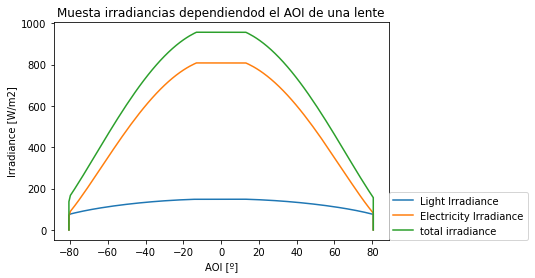

<Figure size 432x288 with 0 Axes>

In [26]:
plt.plot(AOI,light, label='Light Irradiance')
plt.plot(AOI,electricity, label='Electricity Irradiance')
plt.plot(AOI,total_irrad['poa_global'],label='total irradiance')
"plt.plot(AOI,total_irrad['poa_diffuse'],label='diffuse')"
plt.legend(loc=(1.0, 0))
plt.xlabel('AOI [º]')
plt.ylabel('Irradiance [W/m2]')
plt.title('Muesta irradiancias dependiendod el AOI de una lente')
plt.show()
plt.gcf().set_tight_layout(True)

# X DESPLAZADO DEL SPOT RESPECTO EL FOCO DE LA LENTE  DEPENDIENDO DEL AOI

Definimos una función, que basada en la relación que hay entre el aoi, el spot y la distancia focal. La distancia focal será la distancia que hay entre la lente y el módulo fotovoltaico

In [22]:
def get_r(AOI,focal_dist):
    r=focal_dist*m.tan(AOI*m.pi/180)
    "por el convenio establecido:"
    r=-r
    return r

In [24]:
R=[]
for i in AOI:
    R.append(get_r(i,caracteristics_module['focal_distance']))

Dibujamos:

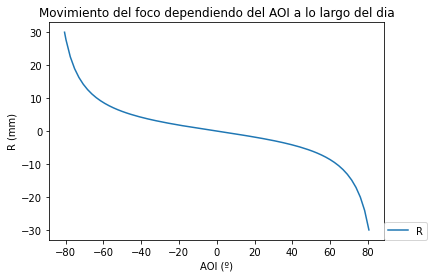

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(AOI,R,label='R')
"plt.plot(AOI,X,label='X')"
"plt.plot(AOI,Y,label='Y')"
plt.legend(loc=(1.0, 0))
plt.xlabel('AOI (º)')
plt.ylabel('R (mm)')
plt.title('Movimiento del foco dependiendo del AOI a lo largo del dia')
plt.show()
plt.gcf().set_tight_layout(True)